## Bildeerkennung mit Hilfe des Caffenet Models 

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
%matplotlib inline

In [50]:
caffe_root = '/opt/caffe/'
sys.path.insert(0, caffe_root + 'python')

In [53]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
caffe.set_mode_cpu()

In [15]:
model_definition = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
net = caffe.Net(model_definition,      # Modellstruktur
                model_weights,         # Trainierte Netzwerkgewichte
                caffe.TEST)            # Nutzt den Test-Modus

In [16]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)
print 'mean-subtracted values:', zip('BGR', mu)

In [19]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

In [20]:
transformer.set_transpose('data', (2,0,1))

In [21]:
transformer.set_mean('data', mu) 

In [22]:
transformer.set_raw_scale('data', 255)

In [23]:
transformer.set_channel_swap('data', (2,1,0))

In [24]:
net.blobs['data'].reshape(50,3,227, 227)

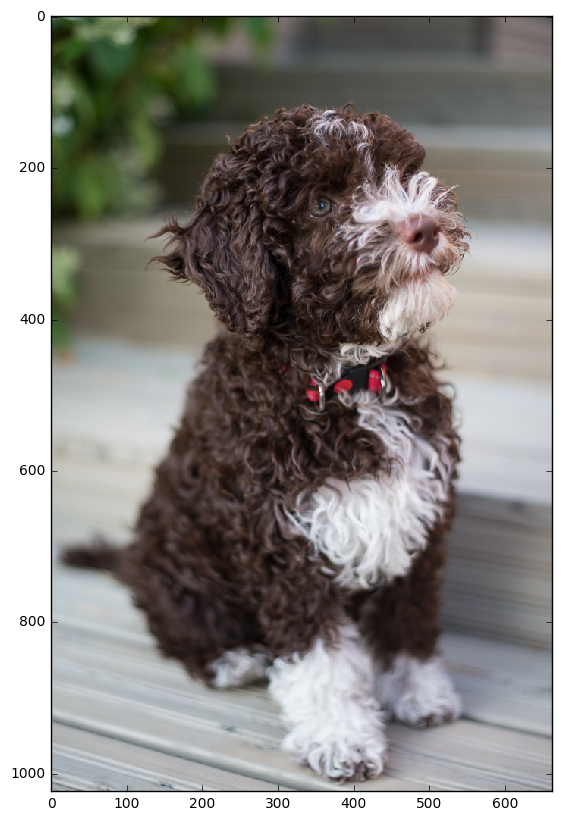

In [54]:
image = caffe.io.load_image("/tmp/lagotto-romagnolo.jpg")
plt.imshow(image)

In [27]:
net.blobs['data'].data[...] = transformed_image
output = net.forward()

In [60]:
transformed_image = transformer.preprocess('data', image)

In [61]:
output_prob = output['prob'][0]

In [62]:
print 'predicted class is:', output_prob.argmax()

predicted class is: 266


In [33]:
label_word = '/opt/caffe/data/ilsvrc12/synset_words.txt'

In [34]:
labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'output label:', labels[output_prob.argmax()]

output label: n02113712 miniature poodle


In [35]:
top_inds = output_prob.argsort()[::-1][:5]

In [36]:
print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.52182692, 'n02113712 miniature poodle'),
 (0.23696239, 'n02113624 toy poodle'),
 (0.11212821, 'n02113799 standard poodle'),
 (0.040653002, 'n02102973 Irish water spaniel'),
 (0.019939825, 'n02102318 cocker spaniel, English cocker spaniel, cocker')]

In [37]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [38]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [39]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

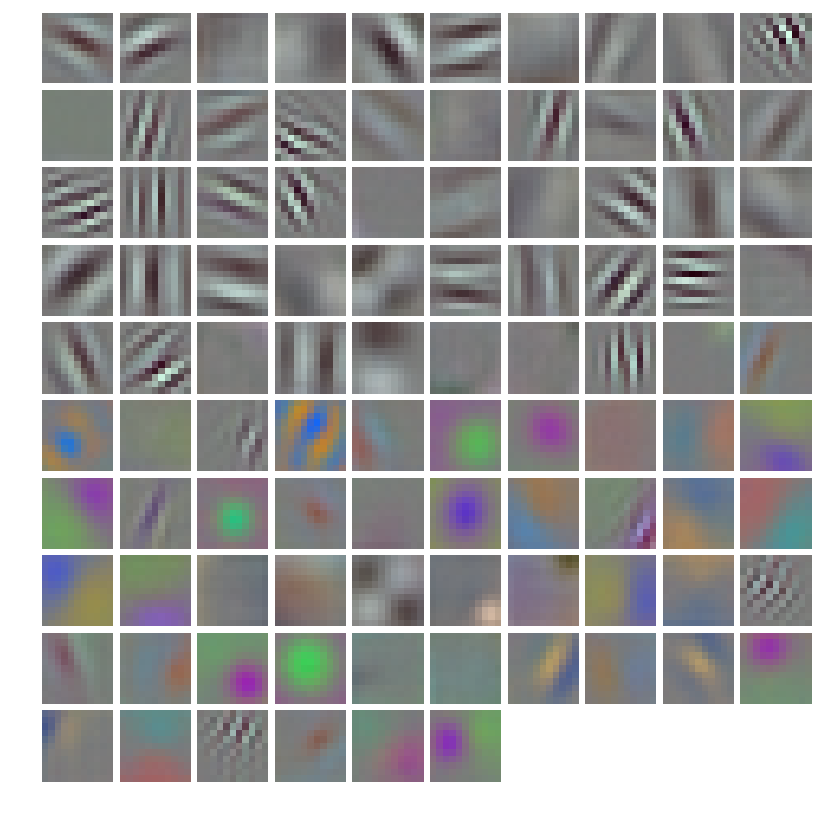

In [44]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

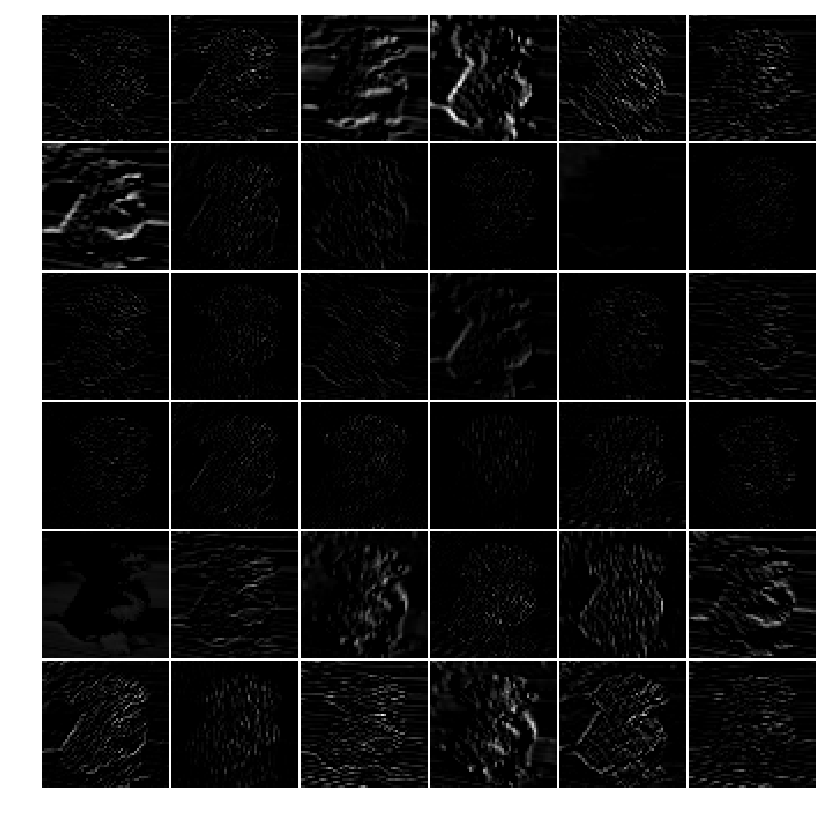

In [41]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

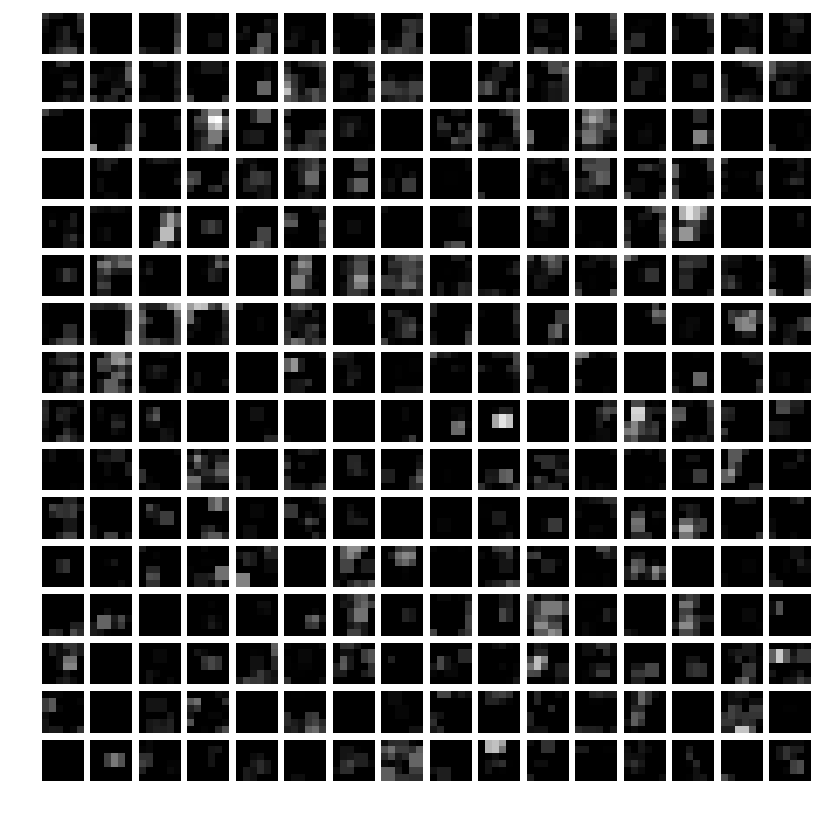

In [42]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)